In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')

# 필요한 함수 정의
def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    #mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day, hour)

def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)


PATH = './data/'

In [2]:
train_err  = pd.read_csv(PATH+'train_err_data.csv')
display(train_err.head())

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


In [3]:
train_user_id_max = 24999
train_user_id_min = 10000
train_user_number = 15000

In [4]:
## days의 변수로 만들기
train_err['datetime'] = train_err['time'].apply(make_datetime)
min_day = train_err.datetime.min().date()

train_err['days'] = train_err.loc[:,'datetime'].dt.date - min_day
train_err['days'] = train_err['days'].dt.days
display(train_err)

,user_id,time,model_nm,fwver,errtype,errcode,datetime,days
0,10000,20201101025616,model_3,05.15.2138,15,1,2020-11-01 02:00:00,1
1,10000,20201101030309,model_3,05.15.2138,12,1,2020-11-01 03:00:00,1
2,10000,20201101030309,model_3,05.15.2138,11,1,2020-11-01 03:00:00,1
3,10000,20201101050514,model_3,05.15.2138,16,1,2020-11-01 05:00:00,1
4,10000,20201101050515,model_3,05.15.2138,4,0,2020-11-01 05:00:00,1
...,...,...,...,...,...,...,...,...
16554658,24999,20201130163051,model_3,05.15.2138,15,1,2020-11-30 16:00:00,30
16554659,24999,20201130172625,model_3,05.15.2138,16,1,2020-11-30 17:00:00,30
16554660,24999,20201130172625,model_3,05.15.2138,4,0,2020-11-30 17:00:00,30
16554661,24999,20201130172631,model_3,05.15.2138,4,0,2020-11-30 17:00:00,30


In [5]:
##시간별 데이터 만드는 코딩
def time_encoding(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    day   = int(x[6:8])
    hour  = int(x[8:10])
    y = day*100 + hour
    for i in range(30):
        if y == (i+1)*100:
            return 0
        if y == (i+1)*100 + 1:
            return 1
        if y == (i+1)*100 + 2:
            return 2
        if y == (i+1)*100 + 3:
            return 3
        if y == (i+1)*100 + 4:
            return 4
        if y == (i+1)*100 + 5:
            return 5
        if y == (i+1)*100 + 6:
            return 6
        if y == (i+1)*100 + 7:
            return 7
        if y == (i+1)*100 + 8:
            return 8
        if y == (i+1)*100 + 9:
            return 9
        if y == (i+1)*100 + 10:
            return 10
        if y == (i+1)*100 + 11:
            return 11
        if y == (i+1)*100 + 12:
            return 12
        if y == (i+1)*100 + 13:
            return 13
        if y == (i+1)*100 + 14:
            return 14
        if y == (i+1)*100 + 15:
            return 15
        if y == (i+1)*100 + 16:
            return 16
        if y == (i+1)*100 + 17:
            return 17
        if y == (i+1)*100 + 18:
            return 18
        if y == (i+1)*100 + 19:
            return 19
        if y == (i+1)*100 + 20:
            return 20
        if y == (i+1)*100 + 21:
            return 21
        if y == (i+1)*100 + 22:
            return 22
        if y == (i+1)*100 + 23:
            return 23
        if day == 31: # 10월 31일 23:59의 경우
            return 0

In [6]:
#적용하기
train_err['timeslot'] = train_err['time'].apply(time_encoding)

In [7]:
train_err[train_err['time']==20201031235959] ## 1031일 확인하기
#timeslot 추가분 /// 31변수가 NAN으로 입력됨
#train_err[train_err['timeslot'].isnull()==True]

## 날짜 데이터는 1031 ~ 1202 까지 존재

,user_id,time,model_nm,fwver,errtype,errcode,datetime,days,timeslot
6409135,15801,20201031235959,model_0,04.22.1750,16,1,2020-10-31 23:00:00,0,0
9204586,18418,20201031235959,model_0,04.22.1750,26,1,2020-10-31 23:00:00,0,0
12134438,20974,20201031235959,model_0,04.22.1750,26,1,2020-10-31 23:00:00,0,0
13424899,22249,20201031235959,model_0,04.22.1750,26,1,2020-10-31 23:00:00,0,0
13585684,22385,20201031235959,model_2,04.33.1185,26,1,2020-10-31 23:00:00,0,0


In [8]:
train_err

,user_id,time,model_nm,fwver,errtype,errcode,datetime,days,timeslot
0,10000,20201101025616,model_3,05.15.2138,15,1,2020-11-01 02:00:00,1,2
1,10000,20201101030309,model_3,05.15.2138,12,1,2020-11-01 03:00:00,1,3
2,10000,20201101030309,model_3,05.15.2138,11,1,2020-11-01 03:00:00,1,3
3,10000,20201101050514,model_3,05.15.2138,16,1,2020-11-01 05:00:00,1,5
4,10000,20201101050515,model_3,05.15.2138,4,0,2020-11-01 05:00:00,1,5
...,...,...,...,...,...,...,...,...,...
16554658,24999,20201130163051,model_3,05.15.2138,15,1,2020-11-30 16:00:00,30,16
16554659,24999,20201130172625,model_3,05.15.2138,16,1,2020-11-30 17:00:00,30,17
16554660,24999,20201130172625,model_3,05.15.2138,4,0,2020-11-30 17:00:00,30,17
16554661,24999,20201130172631,model_3,05.15.2138,4,0,2020-11-30 17:00:00,30,17


In [9]:
train_err=train_err.drop(columns=['datetime','time']) ## 시간처리 완료로 시간 데이터 드랍
#train_err = train_errf.drop(columns=['user_id','model_nm']) #ID 드랍하고 모델넘버는 펌웨어 버전과 연관이 있기에 드랍

In [87]:
len(test_err['errtype'].unique())

41

In [10]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


# 숫자 값으로 변환하기 위해 LabelEncoder로 먼저 변환한다.
encoder = LabelEncoder()
encoder.fit(train_err['fwver'].astype('|S80'))
labels_fwver = encoder.transform(train_err['fwver'].astype('|S80'))
train_err = pd.concat([train_err,pd.Series(labels_fwver)],axis=1)
train_err.rename(columns = {0 : 'labels_fwver'}, inplace = True)

In [11]:
fwver_label = train_err[['user_id','labels_fwver']].values
fwver_check = np.zeros((train_user_number,len(train_err['labels_fwver'].unique())))

for person_idx, ch in tqdm(fwver_label):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    fwver_check[person_idx - train_user_id_min,ch - 1] += 1
fwver_check.shape

100%|██████████████████████████████████████████████████████████████████| 16554663/16554663 [00:45<00:00, 362509.09it/s]


(15000, 37)

In [12]:
days_label = train_err[['user_id','days']].values
days_check = np.zeros((train_user_number,len(train_err['days'].unique())))

for person_idx, ch in tqdm(days_label):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    days_check[person_idx - train_user_id_min,ch - 1] += 1
days_check.shape

100%|██████████████████████████████████████████████████████████████████| 16554663/16554663 [00:45<00:00, 365037.50it/s]


(15000, 33)

In [13]:
timeslot_label = train_err[['user_id','timeslot']].values
timeslot_check = np.zeros((train_user_number,len(train_err['timeslot'].unique())))

for person_idx, ch in tqdm(timeslot_label):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    timeslot_check[person_idx - train_user_id_min,ch - 1] += 1
timeslot_check.shape

100%|██████████████████████████████████████████████████████████████████| 16554663/16554663 [00:47<00:00, 349340.50it/s]


(15000, 24)

In [14]:
id_error = train_err[['user_id','errtype']].values
error = np.zeros((train_user_number,42))

for person_idx, err in tqdm(id_error):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    error[person_idx - train_user_id_min,err - 1] += 1
error.shape

100%|██████████████████████████████████████████████████████████████████| 16554663/16554663 [00:46<00:00, 356025.44it/s]


(15000, 42)

In [15]:
x_concat1 = np.concatenate((fwver_check, days_check), axis=1) ## 펌웨어 버전 + 날짜 
x_concat2 = np.concatenate((x_concat1, timeslot_check), axis=1) ## 펌웨어 버전 + 날짜 +시간 
x_concat3 = np.concatenate((x_concat2, error), axis=1) ## 펌웨어 버전 + 날짜 +시간 + 에러

In [16]:
train_prob = pd.read_csv(PATH+'train_problem_data.csv')
problem = np.zeros(15000)
# error와 동일한 방법으로 person_idx - 10000 위치에 
# person_idx의 problem이 한 번이라도 발생했다면 1
# 없다면 0
problem[train_prob.user_id.unique()-10000] = 1 
problem.shape

(15000,)

In [75]:
# 변수 이름 변경
# error  -> train_x
# problem-> train_y

train_x = x_concat3
train_y = problem

print(train_x.shape)
print(train_y.shape)

(15000, 136)
(15000,)


In [76]:
# Train
#-------------------------------------------------------------------------------------
# validation auc score를 확인하기 위해 정의
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True
#-------------------------------------------------------------------------------------
models     = []
recalls    = []
precisions = []
auc_scores   = []
threshold = 0.5
# 파라미터 설정
params =      {
                'task' : 'train',
                'boosting_type' : 'gbdt',
                'objective'     : 'binary',
                'metric'        : 'auc',
                'learning_rate' : 0.01,
                'max_bin' : 255,
                'feature_fraction' : 0.8,
                'min_data_in_leaf'     : 10,
                'num_threads'    : 4, 
                'seed': 1015
                }
#-------------------------------------------------------------------------------------
# 10 Kfold cross validation
k_fold = KFold(n_splits=10, shuffle=True, random_state=150)
for train_idx, val_idx in k_fold.split(train_x):

    # split train, validation set
    X = train_x[train_idx]
    y = train_y[train_idx]
    valid_x = train_x[val_idx]
    valid_y = train_y[val_idx]

    d_train= lgb.Dataset(X, y)
    d_val  = lgb.Dataset(valid_x, valid_y)
    
    #run traning
    model = lgb.train(
                        params,
                        train_set       = d_train,
                        num_boost_round = 1000,
                        valid_sets      = d_val,
                        feval           = f_pr_auc,
                        verbose_eval    = 20, 
                        early_stopping_rounds = 100
                       )
    
    # cal valid prediction
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)
    
    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)

    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)

    print('==========================================================')

[LightGBM] [Info] Number of positive: 4543, number of negative: 8957
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20429
[LightGBM] [Info] Number of data points in the train set: 13500, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.336519 -> initscore=-0.678848
[LightGBM] [Info] Start training from score -0.678848
Training until validation scores don't improve for 100 rounds
[20]	valid_0's auc: 0.795083	valid_0's pr_auc: 0.705784
[40]	valid_0's auc: 0.80256	valid_0's pr_auc: 0.700218
[60]	valid_0's auc: 0.803912	valid_0's pr_auc: 0.702322
[80]	valid_0's auc: 0.804982	valid_0's pr_auc: 0.709069
[100]	valid_0's auc: 0.806482	valid_0's pr_auc: 0.71071
[120]	valid_0's auc: 0.806358	valid_0's pr_auc: 0.711783
[140]	valid_0's auc: 0.806958	valid_0's pr_auc: 0.714117
[160]	valid_0's auc: 0.806729	valid_0's pr_auc: 

In [77]:
print(np.mean(auc_scores))

0.817275076212649


In [18]:
# 숫자 값으로 변환하기 위해 LabelEncoder로 먼저 변환한다.

encoder.fit(train_err['errcode'].astype('|S80'))
errcode_label = encoder.transform(train_err['errcode'].astype('|S80'))
train_err = pd.concat([train_err,pd.Series(errcode_label)],axis=1)
train_err.rename(columns = {0 : 'errcode_label'}, inplace = True)

In [19]:
errcode_label_ = train_err[['user_id','errcode_label']].values
errcode_check = np.zeros((train_user_number,len(train_err['errcode_label'].unique())))

for person_idx, ch in tqdm(errcode_label_):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    errcode_check[person_idx - train_user_id_min,ch - 1] += 1
errcode_check.shape

100%|██████████████████████████████████████████████████████████████████| 16554663/16554663 [00:47<00:00, 347135.61it/s]


(15000, 2806)

In [20]:
# errcode를 모델에 적용
x_concat4 = np.concatenate((x_concat3, errcode_check), axis=1) ## 펌웨어 버전 + 날짜 +시간 + 에러 + 에러코드


In [21]:
# 변수 이름 변경
# error  -> train_x
# problem-> train_y

train_x = x_concat4
train_y = problem
print(train_x.shape)
print(train_y.shape)

(15000, 2942)
(15000,)


In [22]:
# Train
#-------------------------------------------------------------------------------------
# validation auc score를 확인하기 위해 정의
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True
#-------------------------------------------------------------------------------------
models     = []
recalls    = []
precisions = []
auc_scores   = []
threshold = 0.5
# 파라미터 설정
params =      {
                'task' : 'train',
                'boosting_type' : 'gbdt',
                'objective'     : 'binary',
                'metric'        : 'auc',
                'learning_rate' : 0.01,
                'max_bin' : 255,
                'feature_fraction' : 0.8,
                'min_data_in_leaf'     : 10,
                'num_threads'    : 4, 
                'seed': 1015
                }
#-------------------------------------------------------------------------------------
# 10 Kfold cross validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=150)
for train_idx, val_idx in k_fold.split(train_x):

    # split train, validation set
    X = train_x[train_idx]
    y = train_y[train_idx]
    valid_x = train_x[val_idx]
    valid_y = train_y[val_idx]

    d_train= lgb.Dataset(X, y)
    d_val  = lgb.Dataset(valid_x, valid_y)
    
    #run traning
    model = lgb.train(
                        params,
                        train_set       = d_train,
                        num_boost_round = 1000,
                        valid_sets      = d_val,
                        feval           = f_pr_auc,
                        verbose_eval    = 20, 
                        early_stopping_rounds = 100
                       )
    
    # cal valid prediction
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)
    
    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)

    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)

    print('==========================================================')

[LightGBM] [Info] Number of positive: 4064, number of negative: 7936
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24238
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 194
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.338667 -> initscore=-0.669242
[LightGBM] [Info] Start training from score -0.669242
Training until validation scores don't improve for 100 rounds
[20]	valid_0's auc: 0.814044	valid_0's pr_auc: 0.720993
[40]	valid_0's auc: 0.815765	valid_0's pr_auc: 0.721679
[60]	valid_0's auc: 0.816988	valid_0's pr_auc: 0.723167
[80]	valid_0's auc: 0.818262	valid_0's pr_auc: 0.725336
[100]	valid_0's auc: 0.818716	valid_0's pr_auc: 0.726012
[120]	valid_0's auc: 0.819472	valid_0's pr_auc: 0.728201
[140]	valid_0's auc: 0.820318	valid_0's pr_auc: 0.727212
[160]	valid_0's auc: 0.821708	valid_0's pr_auc

In [23]:
print(np.mean(auc_scores))

0.8219797356940377


In [24]:
from pycaret.classification import *

In [25]:
X = pd.DataFrame(x_concat4)
y = pd.DataFrame(problem)

In [26]:
X['problem'] = problem

In [27]:
clf = setup(data = X, target = 'problem') 

,Description,Value
0,session_id,3113
1,Target,problem
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(15000, 2943)"
5,Missing Values,False
6,Numeric Features,665
7,Categorical Features,2277
8,Ordinal Features,False
9,High Cardinality Features,False


In [28]:
best_5 = compare_models(sort = 'Accuracy', n_select = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7923,0.8236,0.4964,0.8091,0.6151,0.4839,0.5110,43.3230
lightgbm,Light Gradient Boosting Machine,0.7877,0.8178,0.5073,0.7824,0.6152,0.4777,0.4992,0.7380
gbc,Gradient Boosting Classifier,0.7856,0.8142,0.4657,0.8149,0.5924,0.4612,0.4946,9.4830
xgboost,Extreme Gradient Boosting,0.7785,0.8013,0.5258,0.7368,0.6134,0.4642,0.4774,14.5910
ada,Ada Boost Classifier,0.7753,0.7934,0.4711,0.7683,0.5837,0.4418,0.4667,2.5000
et,Extra Trees Classifier,0.7745,0.7977,0.4253,0.8117,0.5577,0.4256,0.4658,4.4810
rf,Random Forest Classifier,0.7678,0.7943,0.4071,0.8027,0.5397,0.4059,0.4480,2.1190
ridge,Ridge Classifier,0.7414,0.0000,0.3365,0.7555,0.4649,0.3263,0.3729,2.9680
lda,Linear Discriminant Analysis,0.7402,0.7196,0.3524,0.7337,0.4755,0.3301,0.3696,6.2730
lr,Logistic Regression,0.7354,0.7387,0.3467,0.7167,0.4665,0.3182,0.3555,15.6540


In [29]:
blended_5 = blend_models(estimator_list = best_5, fold = 10, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8048,0.8465,0.5128,0.8411,0.6372,0.5141,0.5436
1,0.7867,0.8330,0.4900,0.7926,0.6056,0.4703,0.4959
2,0.7914,0.8161,0.4701,0.8333,0.6011,0.4743,0.5100
3,0.7733,0.8000,0.4701,0.7604,0.5810,0.4372,0.4610
4,0.8067,0.8454,0.5214,0.8394,0.6432,0.5204,0.5481
5,0.7857,0.8108,0.5128,0.7692,0.6154,0.4750,0.4937
6,0.7905,0.8267,0.4915,0.8084,0.6113,0.4793,0.5071
7,0.7914,0.8324,0.5085,0.7956,0.6205,0.4861,0.5092
8,0.7810,0.8034,0.4688,0.7933,0.5893,0.4531,0.4822
9,0.7893,0.8239,0.5128,0.7826,0.6196,0.4825,0.5032


In [30]:
pred_holdout = predict_model(blended_5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7934,0.8176,0.4976,0.8017,0.6141,0.4834,0.5090


In [31]:
final_model = finalize_model(blended_5)

In [ ]:
best_2 = compare_models(sort = 'Accuracy', n_select = 2)

In [ ]:
blended_2 = blend_models(estimator_list = best_2, fold = 10, method = 'soft')

In [ ]:
pred_holdout = predict_model(blended_2)

In [32]:
test_err = pd.read_csv(PATH+'test_err_data.csv')

In [33]:
id_error = test_err[['user_id','errtype']].values
test_x = np.zeros((14999,42))
for person_idx, err in tqdm(id_error):
    test_x[person_idx - 30000,err - 1] += 1
test_x = test_x.reshape(test_x.shape[0],-1)
test = pd.DataFrame(data=test_x)

100%|██████████████████████████████████████████████████████████████████| 16532648/16532648 [00:50<00:00, 325830.06it/s]


In [34]:
## days의 변수로 만들기
test_err['datetime'] = test_err['time'].apply(make_datetime)
min_day = test_err.datetime.min().date()

test_err['days'] = test_err.loc[:,'datetime'].dt.date - min_day
test_err['days'] = test_err['days'].dt.days
display(test_err)

,user_id,time,model_nm,fwver,errtype,errcode,datetime,days
0,30000,20201101030227,model_1,04.16.3553,31,1,2020-11-01 03:00:00,1
1,30000,20201101030227,model_1,04.16.3553,33,2,2020-11-01 03:00:00,1
2,30000,20201101030228,model_1,04.16.3553,15,1,2020-11-01 03:00:00,1
3,30000,20201101030256,model_1,04.16.3553,22,1,2020-11-01 03:00:00,1
4,30000,20201101030300,model_1,04.16.3553,11,1,2020-11-01 03:00:00,1
...,...,...,...,...,...,...,...,...
16532643,44998,20201130210050,model_1,04.16.3553,40,0,2020-11-30 21:00:00,30
16532644,44998,20201130211831,model_1,04.16.3553,31,1,2020-11-30 21:00:00,30
16532645,44998,20201130211832,model_1,04.16.3553,15,1,2020-11-30 21:00:00,30
16532646,44998,20201130212259,model_1,04.16.3553,16,1,2020-11-30 21:00:00,30


In [35]:
#적용하기
test_err['timeslot'] = test_err['time'].apply(time_encoding)

In [36]:
test_user_id_max = 44998
test_user_id_min = 30000
test_user_number = 14999

In [37]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


# 숫자 값으로 변환하기 위해 LabelEncoder로 먼저 변환한다.
encoder = LabelEncoder()
encoder.fit(test_err['fwver'].astype('|S80'))
labels_fwver = encoder.transform(test_err['fwver'].astype('|S80'))
test_err = pd.concat([test_err,pd.Series(labels_fwver)],axis=1)
test_err.rename(columns = {0 : 'labels_fwver'}, inplace = True)

In [38]:
fwver_label_test = test_err[['user_id','labels_fwver']].values
fwver_check_test = np.zeros((test_user_number,len(test_err['labels_fwver'].unique())))

for person_idx, ch in tqdm(fwver_label_test):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    fwver_check_test[person_idx - test_user_id_min,ch - 1] += 1
fwver_check_test.shape

100%|██████████████████████████████████████████████████████████████████| 16532648/16532648 [00:48<00:00, 337514.72it/s]


(14999, 40)

In [39]:
days_label_test = test_err[['user_id','days']].values
days_check_test = np.zeros((test_user_number,max(test_err['days'])))

for person_idx, ch in tqdm(days_label_test):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    days_check_test[person_idx - test_user_id_min,ch-1] += 1
days_check_test.shape

100%|██████████████████████████████████████████████████████████████████| 16532648/16532648 [00:46<00:00, 354060.94it/s]


(14999, 44)

In [40]:
len(test_err['labels_fwver'].unique())

40

In [41]:
timeslot_label_test = test_err[['user_id','timeslot']].values
timeslot_check_test = np.zeros((test_user_number,len(test_err['timeslot'].unique())))

for person_idx, ch in tqdm(timeslot_label_test):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    timeslot_check_test[person_idx - test_user_id_min,ch - 1] += 1
timeslot_check_test.shape

100%|██████████████████████████████████████████████████████████████████| 16532648/16532648 [00:48<00:00, 342740.61it/s]


(14999, 24)

In [100]:
timeslot_check_test

array([[  36.,   75.,  132., ...,  113.,   55.,   37.],
       [   6.,    8.,    2., ...,    9.,   19.,   10.],
       [  28.,   33.,    7., ...,   14.,   16.,   30.],
       ...,
       [  19.,   21.,   20., ...,  189.,   50.,   97.],
       [ 921.,  813.,  782., ..., 1213., 1512., 1032.],
       [  59.,  141.,   18., ...,   36.,   20.,   48.]])

In [ ]:
### 드랍할거 하기

In [42]:
error_label_test = test_err[['user_id','errtype']].values
error_check_test = np.zeros((test_user_number,42))

for person_idx, err in tqdm(error_label_test):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    error_check_test[person_idx - test_user_id_min,err - 1] += 1
error_check_test.shape

100%|██████████████████████████████████████████████████████████████████| 16532648/16532648 [00:47<00:00, 347159.61it/s]


(14999, 42)

In [43]:
x_test1 = np.concatenate((fwver_check_test, days_check_test), axis=1) ## 펌웨어 버전 + 날짜 
x_test2 = np.concatenate((x_test1, timeslot_check_test), axis=1) ## 펌웨어 버전 + 날짜 +시간 
x_test3 = np.concatenate((x_test2, error_check_test), axis=1) ## 펌웨어 버전 + 날짜 +시간 + 에러

In [44]:
#숫자 값으로 변환하기 위해 LabelEncoder로 먼저 변환한다.

encoder.fit(test_err['errcode'].astype('|S80'))
errcode_label = encoder.transform(test_err['errcode'].astype('|S80'))
test_err = pd.concat([test_err,pd.Series(errcode_label)],axis=1)
test_err.rename(columns = {0 : 'errcode_label'}, inplace = True)

In [45]:
errcode_label_test = test_err[['user_id','errcode_label']].values
errcode_check_test = np.zeros((test_user_number,len(test_err['errcode_label'].unique())))

for person_idx, ch in tqdm(errcode_label_test):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    errcode_check_test[person_idx - test_user_id_min,ch - 1] += 1
errcode_check_test.shape

100%|██████████████████████████████████████████████████████████████████| 16532648/16532648 [00:46<00:00, 356607.92it/s]


(14999, 2956)

In [46]:
# errcode를 모델에 적용
x_test4 = np.concatenate((x_test3, errcode_check_test), axis=1) ## 펌웨어 버전 + 날짜 +시간 + 에러 + 에러코드

In [47]:
x_test4.shape

(14999, 3106)

In [48]:
X_test = pd.DataFrame(x_test4)

In [49]:
predictions = predict_model(final_model, data = X_test)

#pycaret에서는 score이 label을 맞출 확률이기때문에 output을 제출 양식에 맞게 바꿔줍니다
x = []
for i in range(len(predictions['Score'])):
  if predictions['Label'][i] =='1.0':
    x.append(predictions['Score'][i])
  else:
    x.append(1-predictions['Score'][i])


In [50]:
sample_submssion = pd.read_csv(PATH+'sample_submission.csv')
sample_submssion['problem'] = x
sample_submssion.to_csv("best_5.csv", index = False)

In [52]:
X = pd.DataFrame(x_concat3)
y = pd.DataFrame(problem)

In [60]:
X['problem'] = problem

In [67]:
clf = setup(data = X, target = 'problem') 

,Description,Value
0,session_id,4858
1,Target,problem
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(15000, 137)"
5,Missing Values,False
6,Numeric Features,126
7,Categorical Features,10
8,Ordinal Features,False
9,High Cardinality Features,False


In [68]:
best_5 = compare_models(sort = 'Accuracy', n_select = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7906,0.8155,0.4942,0.8102,0.6136,0.4814,0.5092,17.0110
lightgbm,Light Gradient Boosting Machine,0.7826,0.8042,0.4939,0.7801,0.6045,0.4649,0.4881,0.4600
gbc,Gradient Boosting Classifier,0.7824,0.8087,0.4600,0.8122,0.5870,0.4543,0.4883,3.0120
et,Extra Trees Classifier,0.7769,0.8029,0.4622,0.7881,0.5823,0.4440,0.4736,0.8760
rf,Random Forest Classifier,0.7747,0.8016,0.4430,0.7992,0.5694,0.4335,0.4684,1.0810
xgboost,Extreme Gradient Boosting,0.7735,0.7911,0.5185,0.7309,0.6063,0.4538,0.4672,2.0780
ada,Ada Boost Classifier,0.7705,0.7851,0.4716,0.7554,0.5804,0.4339,0.4569,0.6160
lda,Linear Discriminant Analysis,0.7455,0.7359,0.3327,0.7913,0.4679,0.3355,0.3901,0.1220
ridge,Ridge Classifier,0.7454,0.0000,0.3245,0.8023,0.4617,0.3322,0.3907,0.0460
lr,Logistic Regression,0.7384,0.7455,0.3457,0.7388,0.4704,0.3259,0.3676,2.1050


In [69]:
blended_5 = blend_models(estimator_list = best_5, fold = 10, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7810,0.8100,0.4533,0.8122,0.5818,0.4492,0.4842
1,0.7895,0.8127,0.5071,0.7920,0.6183,0.4825,0.5054
2,0.7857,0.8379,0.4533,0.8333,0.5872,0.4590,0.4978
3,0.7819,0.8027,0.4731,0.7952,0.5933,0.4571,0.4859
4,0.7971,0.8234,0.4887,0.8439,0.6190,0.4938,0.5280
5,0.7933,0.8193,0.4774,0.8408,0.6090,0.4827,0.5184
6,0.7981,0.8183,0.4944,0.8413,0.6228,0.4973,0.5301
7,0.7971,0.8427,0.4944,0.8373,0.6217,0.4953,0.5275
8,0.7810,0.7933,0.4548,0.8131,0.5833,0.4504,0.4854
9,0.7846,0.8048,0.4533,0.8290,0.5861,0.4569,0.4949


In [70]:
pred_holdout = predict_model(blended_5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7932,0.8159,0.4792,0.8069,0.6013,0.4736,0.5029


In [71]:
final_model = finalize_model(blended_5)

In [72]:
X_test = pd.DataFrame(x_test3)

In [73]:
predictions = predict_model(final_model, data = X_test)

#pycaret에서는 score이 label을 맞출 확률이기때문에 output을 제출 양식에 맞게 바꿔줍니다
x = []
for i in range(len(predictions['Score'])):
  if predictions['Label'][i] =='1.0':
    x.append(predictions['Score'][i])
  else:
    x.append(1-predictions['Score'][i])


In [74]:
sample_submssion = pd.read_csv(PATH+'sample_submission.csv')
sample_submssion['problem'] = x
sample_submssion.to_csv("best_5.csv", index = False)

In [121]:
### 모형을 돌려본 결과 테스트와 트레인의 차원이 달라 예측값이 매우 낮게 발생함.
## 고로 차원이 비슷한 결과물 끼리 돌리기로 결정
x_concat_e = np.concatenate((timeslot_check, error), axis=1) ## 시간 + 에러
x_concat_elog = np.concatenate((np.log1p(timeslot_check), np.log1p(error)), axis=1)# 로그변환-시간 + 에러

In [91]:
# 변수 이름 변경
# error  -> train_x
# problem-> train_y

train_x = x_concat_e
train_y = problem

print(train_x.shape)
print(train_y.shape)

(15000, 66)
(15000,)


In [92]:
# Train
#-------------------------------------------------------------------------------------
# validation auc score를 확인하기 위해 정의
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True
#-------------------------------------------------------------------------------------
models     = []
recalls    = []
precisions = []
auc_scores   = []
threshold = 0.5
# 파라미터 설정
params =      {
                'task' : 'train',
                'boosting_type' : 'gbdt',
                'objective'     : 'binary',
                'metric'        : 'auc',
                'learning_rate' : 0.01,
                'max_bin' : 255,
                'feature_fraction' : 0.8,
                'min_data_in_leaf'     : 10,
                'num_threads'    : 4, 
                'seed': 1015
                }
#-------------------------------------------------------------------------------------
# 10 Kfold cross validation
k_fold = KFold(n_splits=10, shuffle=True, random_state=150)
for train_idx, val_idx in k_fold.split(train_x):

    # split train, validation set
    X = train_x[train_idx]
    y = train_y[train_idx]
    valid_x = train_x[val_idx]
    valid_y = train_y[val_idx]

    d_train= lgb.Dataset(X, y)
    d_val  = lgb.Dataset(valid_x, valid_y)
    
    #run traning
    model = lgb.train(
                        params,
                        train_set       = d_train,
                        num_boost_round = 1000,
                        valid_sets      = d_val,
                        feval           = f_pr_auc,
                        verbose_eval    = 20, 
                        early_stopping_rounds = 100
                       )
    
    # cal valid prediction
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)
    
    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)

    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)

    print('==========================================================')

[LightGBM] [Info] Number of positive: 4543, number of negative: 8957
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10767
[LightGBM] [Info] Number of data points in the train set: 13500, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.336519 -> initscore=-0.678848
[LightGBM] [Info] Start training from score -0.678848
Training until validation scores don't improve for 100 rounds
[20]	valid_0's auc: 0.792145	valid_0's pr_auc: 0.696888
[40]	valid_0's auc: 0.793589	valid_0's pr_auc: 0.692737
[60]	valid_0's auc: 0.796053	valid_0's pr_auc: 0.695539
[80]	valid_0's auc: 0.797866	valid_0's pr_auc: 0.697197
[100]	valid_0's auc: 0.797833	valid_0's pr_auc: 0.696824
[120]	valid_0's auc: 0.798467	valid_0's pr_auc: 0.698885
[140]	valid_0's auc: 0.799604	valid_0's pr_auc: 0.700916
[160]	valid_0's auc: 0.800373	valid_0's pr_auc:

In [93]:
print(np.mean(auc_scores))

0.8054116803869326


In [95]:
x_test_e = np.concatenate((timeslot_check_test, error_check_test), axis=1) ## 시간 + 에러

In [96]:
pred_y_list = []
for model in models:
    pred_y = model.predict(x_test_e)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)

In [97]:
pred_ensemble

array([[0.79977784],
       [0.21867192],
       [0.30318728],
       ...,
       [0.47421426],
       [0.81242244],
       [0.33513297]])

In [98]:
sample_submssion = pd.read_csv(PATH+'sample_submission.csv')

sample_submssion['problem'] = pred_ensemble.reshape(-1)

sample_submssion.to_csv("dacon_baseline.csv", index = False)
sample_submssion

,user_id,problem
0,30000,0.799778
1,30001,0.218672
2,30002,0.303187
3,30003,0.552933
4,30004,0.555206
...,...,...
14994,44994,0.343052
14995,44995,0.323713
14996,44996,0.474214
14997,44997,0.812422


array([[10000,     2],
       [10000,     3],
       [10000,     3],
       ...,
       [24999,    17],
       [24999,    17],
       [24999,    21]], dtype=int64)

In [122]:
## 로그 변환된 분석

train_x = x_concat_elog
train_y = problem

print(train_x.shape)
print(train_y.shape)

(15000, 66)
(15000,)


In [131]:
# Train
#-------------------------------------------------------------------------------------
# validation auc score를 확인하기 위해 정의
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True
#-------------------------------------------------------------------------------------
models     = []
recalls    = []
precisions = []
auc_scores   = []
threshold = 0.5
# 파라미터 설정
params =      {
                'task' : 'train',
                'boosting_type' : 'gbdt',
                'objective'     : 'binary',
                'metric'        : 'auc',
                'learning_rate' : 0.01,
                'max_bin' : 255,
                'feature_fraction' : 0.8,
                'min_data_in_leaf'     : 10,
                'num_threads'    : 4, 
                'seed': 1015
                }
#-------------------------------------------------------------------------------------
# 10 Kfold cross validation
k_fold = KFold(n_splits=10, shuffle=True, random_state=50)
for train_idx, val_idx in k_fold.split(train_x):

    # split train, validation set
    X = train_x[train_idx]
    y = train_y[train_idx]
    valid_x = train_x[val_idx]
    valid_y = train_y[val_idx]

    d_train= lgb.Dataset(X, y)
    d_val  = lgb.Dataset(valid_x, valid_y)
    
    #run traning
    model = lgb.train(
                        params,
                        train_set       = d_train,
                        num_boost_round = 1000,
                        valid_sets      = d_val,
                        feval           = f_pr_auc,
                        verbose_eval    = 20, 
                        early_stopping_rounds = 20
                       )
    
    # cal valid prediction
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)
    
    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)

    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)

    print('==========================================================')

[LightGBM] [Info] Number of positive: 4495, number of negative: 9005
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10750
[LightGBM] [Info] Number of data points in the train set: 13500, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.332963 -> initscore=-0.694814
[LightGBM] [Info] Start training from score -0.694814
Training until validation scores don't improve for 20 rounds
[20]	valid_0's auc: 0.796425	valid_0's pr_auc: 0.711435
Early stopping, best iteration is:
[12]	valid_0's auc: 0.797252	valid_0's pr_auc: 0.71512
[LightGBM] [Info] Number of positive: 4504, number of negative: 8996
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002448 seconds.
You can set `force_row_wise=true` to remove the overhead.

In [132]:
print(np.mean(auc_scores))

0.7924054448591031


In [134]:
x_test_elog = np.concatenate((np.log1p(timeslot_check_test), np.log1p(error_check_test)), axis=1) ## 로그변환-시간 + 에러

In [135]:
pred_y_list = []
for model in models:
    pred_y = model.predict(x_test_elog)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)

In [136]:
pred_ensemble

array([[0.40775712],
       [0.30880252],
       [0.32820013],
       ...,
       [0.35218885],
       [0.4262475 ],
       [0.32975762]])

In [112]:
plot(timeslot_check_test)

NameError: name 'plot' is not defined

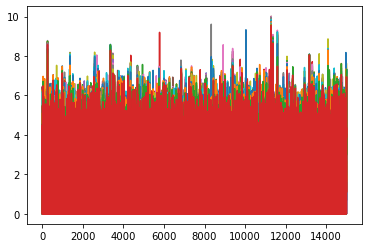

In [114]:
plt.plot(np.log1p(timeslot_check_test)) 


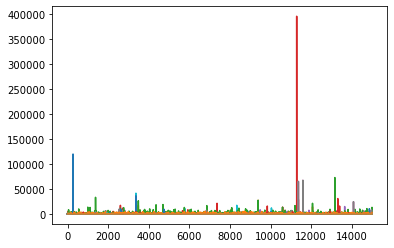

In [115]:
plt.plot(error_check_test)